In [1]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle

In [2]:
x = np.array([[1, 2],
              [1.5, 1.8],
              [5, 8 ],
              [8, 8],
              [1, 0.6],
              [9,11],
              [8,2],
              [10,2],
              [9,3],])

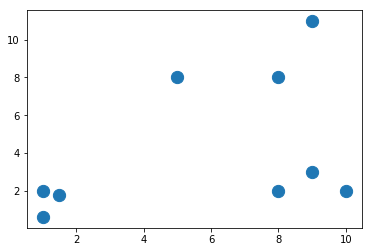

In [3]:
plt.scatter(x[:,0], x[:,1], s=150)
plt.show()

In [4]:
def similarity(xi, xj):
    return -((xi - xj)**2).sum()

def create_matrices():
    S = np.zeros((x.shape[0], x.shape[0]))
    R = np.array(S)
    A = np.array(S)
    
    # compute similarity for every data point.
    for i in range(x.shape[0]):
        for k in range(x.shape[0]):
            S[i, k] = similarity(x[i], x[k])
            
    return A, R, S

In [5]:
def update_r(damping=0.9):
    global R

    v = S + A
    rows = np.arange(x.shape[0])
    
    np.fill_diagonal(v, -np.inf)

    idx_max = np.argmax(v, axis=1)
    first_max = v[rows, idx_max]

    v[rows, idx_max] = -np.inf
    second_max = v[rows, np.argmax(v, axis=1)]

    max_matrix = np.zeros_like(R) + first_max[:, None]
    max_matrix[rows, idx_max] = second_max

    new_val = S - max_matrix

    R = R * damping + (1 - damping) * new_val

In [6]:
def update_a(damping=0.9):
    global A

    k_k_idx = np.arange(x.shape[0])
    
    a = np.array(R)
    a[a < 0] = 0
    np.fill_diagonal(a, 0)
    a = a.sum(axis=0) 
    a = a + R[k_k_idx, k_k_idx]

    a = np.ones(A.shape) * a

    a -= np.clip(R, 0, np.inf)
    a[a > 0] = 0

    w = np.array(R)
    np.fill_diagonal(w, 0)

    w[w < 0] = 0

    a[k_k_idx, k_k_idx] = w.sum(axis=0) 
    A = A * damping + (1 - damping) * a

In [7]:
A, R, S = create_matrices()
preference = np.median(S)
np.fill_diagonal(S, preference)
damping = 0.5

figures = []
last_sol = np.ones(A.shape)
last_exemplars = np.array([])

In [8]:
def plot_iteration(A, R):
    fig = plt.figure(figsize=(12, 6))
    sol = A + R
    labels = np.argmax(sol, axis=1)
    exemplars = np.unique(labels)
    colors = dict(zip(exemplars, cycle('bgrcmyk')))
    
    for i in range(len(labels)):
        X = x[i][0]
        Y = x[i][1]
        
        if i in exemplars:
            exemplar = i
            edge = 'k'
            ms = 10
        else:
            exemplar = labels[i]
            ms = 3
            edge = None
            plt.plot([X, x[exemplar][0]], [Y, x[exemplar][1]], c=colors[exemplar])
        plt.plot(X, Y, 'o', markersize=ms,  markeredgecolor=edge, c=colors[exemplar])
        

    plt.title('Number of exemplars: %s' % len(exemplars))
    return fig, labels, exemplars

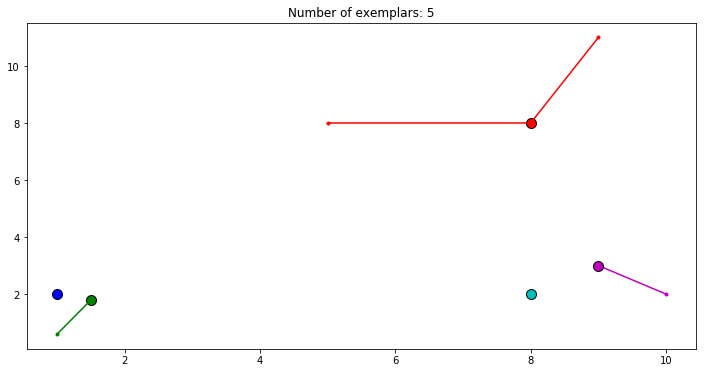

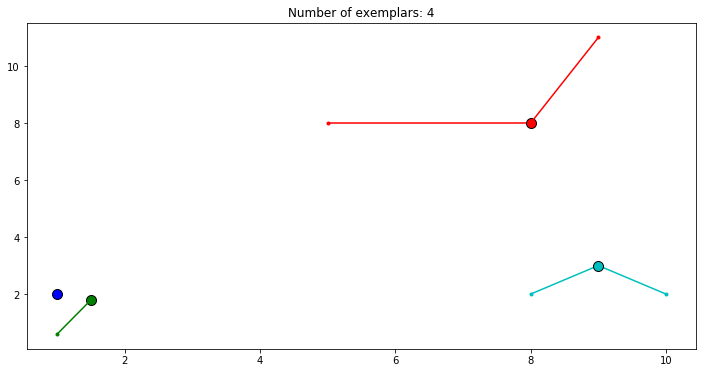

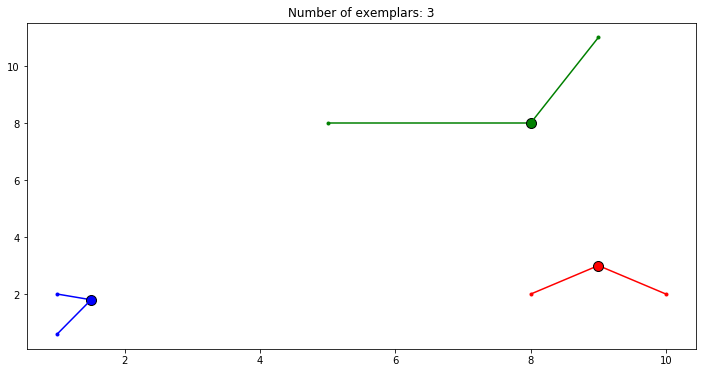

In [10]:
c = 0
for i in range(200):
    update_r(damping)
    update_a(damping)
    
    sol = A + R
    exemplars = np.unique(np.argmax(sol, axis=1))
    
    if last_exemplars.size != exemplars.size or np.all(last_exemplars != exemplars):
        fig, labels, exemplars = plot_iteration(A, R)
        figures.append(fig)
    
    if np.allclose(last_sol, sol):
        print(exemplars, i)
        break
        
    last_sol = sol
    last_exemplars = exemplars